## sources / tutorials: <br>
https://mxnet.incubator.apache.org/api/python/module/module.html -> Module <br>
https://mxnet.incubator.apache.org/tutorials/basic/module.html -> Introduction to Module <br>
http://mxnet.dmlc.ml/api/python/rnn.html -> RNN Modul <br> <br> <br>
Warum mxnet? -> https://blog.kovalevskyi.com/distributed-mxnet-can-it-be-scaled-linearly-7a1ad7c28474

<br>
## IMPORTS

In [1]:
import mxnet as mx
from mxnet import nd, autograd
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime
import math
import time
import logging
logging.basicConfig(level=logging.DEBUG)



C:\Users\Flo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\Flo\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


<br>
## WORKING-FUNCTIONS

In [2]:
# expect something like this (e.g.): plot_dataframe_with_args([source_data_x,source_data_y,color],[result_data_x, result_data_y, color]) 
def plot_dataframe_with_args(*args):#(x_source, y_source, color_source, x_results, y_results, color_results, add_offset = False):
#     for i in args:
#         if i != args[0]:
    plt.figure(figsize=(60, 25))
    plt.title('stock market prediction - Prediction on Prediction')
    plt.xlabel('days')
    plt.ylabel('dayli-closing-price in Dollar')
    for i in args:
        plt.plot(i[0],i[1],i[2]) 
    plt.show()

In [3]:
def read_dataframe_and_output_dataset():
    data_set = np.arange(0,8*math.pi,0.2)
    data_to_use = [math.sin(x) + 0.1*math.sin(10*x) for x in data_set]
    #data_to_use = [math.sin(x) for x in data_set]
    data_to_use = [math.sin(x) + 0.5*math.sin(2*x) for x in data_set]
    
    return data_to_use
    

In [4]:
def scale_dataset(min,max,dataset): #dataset shape: [x]
    scaler = MinMaxScaler(feature_range=(min,max))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaler, scaled_dataset

In [5]:
def scale_dataset_back(scaler, dataset): #dataset shape: [x]
    return scaler.inverse_transform(dataset)

In [6]:
#if reshaped = False ->(None) to (None,1)
#if reshaped = True -> (None,1) to (None)
def reshape_dataset(dataset, reshaped):
    if reshaped is False:
        dataset = np.reshape(dataset, (-1,1))
    else:
        dataset = np.reshape(dataset, (-1))
    return dataset
    

In [7]:
#requires dataset of shape (-1,1)
def window_data(reshaped_data, window_size):
    x = []
    y = []    
    i = 0
    while (i + window_size) <= len(reshaped_data) - 1: #heißt eigentlich nach windowsSize Tagen = eine Prediction
        x.append(reshaped_data[i:i+window_size])
        y.append(reshaped_data[i+window_size])        
        i += 1
    assert len(x) ==  len(y)
    return x, y

In [8]:
#requires windowed_dataset
def create_trains(windowed_data_x,windowed_data_y, train_range):
    x_train  = np.array(windowed_data_x[:train_range])
    y_train = np.array(windowed_data_y[:train_range])

    x_test = np.array(windowed_data_x[train_range:])
    y_test = np.array(windowed_data_y[train_range:])
    return x_train, y_train, x_test, y_test

In [9]:
def return_filled_trains(window_size, train_range):
    data_set = read_dataframe_and_output_dataset()
    reshaped_data_set = reshape_dataset(data_set,False)
    scaler , scaled_dataset = scale_dataset(-1,1,reshaped_data_set)
    x_windowed, y_windowed = window_data(scaled_dataset, window_size)
    x_train,y_train, x_test, y_test = create_trains(x_windowed, y_windowed, train_range)
    return x_train,y_train, x_test, y_test
    

In [10]:
def return_filled_iterators(x_train,y_train, x_test, y_test,batch_size,shuffle=False):
    train_iter = mx.io.NDArrayIter(data={'data': x_train},label={'data_label':y_train},batch_size=batch_size, shuffle=shuffle)
    val_iter = mx.io.NDArrayIter(x_test, y_test, batch_size=5)
    return train_iter, val_iter

In [11]:
def print_informations_about_train_and_test_data(training_output,testing_output):
    print("Number of Trainings-predictions: ", len(training_output))
    print("Shape of Trainings_predictions: ", training_output.shape, "\n")
    print("Number of Predictions: ", len(testing_output))
    print("Shape of Predictions: ", testing_output.shape)

In [12]:
def reshape_trainings_outputs(training_output):
    return np.array(training_output).reshape(-1)

In [13]:
def convert_data_of_iterator_to_numpy_array(train_iterator):
    train_iterator.reset()
    return np.array([i.data[0].asnumpy() for i in train_iterator]).reshape(-1)

<br>
## MAKE-MODULE

In [14]:
#missing: forloop for more SequentialRNNCells

def return_created_module(window_size,ctx,neurons_at_gate,num_hidden_output_layer): 
    batch_input_variable = mx.symbol.Variable('data') #'seq_data' has the shape of (batch_size, window_size).
    batch_label_variable = mx.symbol.Variable('data_label') # muss so heissen wegen iterator, der mapped die bath werte auf die hier gegebenen variablen namen
    stacked_rnn_cells = mx.rnn.SequentialRNNCell()
    stacked_rnn_cells.add(mx.rnn.LSTMCell(num_hidden=neurons_at_gate))
    stacked_rnn_cells.reset()
        #begin_state = stacked_rnn_cells.begin_state()
    outputs_lstm, states_lstm = stacked_rnn_cells.unroll(length=window_size, inputs=batch_input_variable,layout='NTC',merge_outputs=True) 
        ## In the layout, 'N' represents batch size, 'T' represents sequence length, and 'C' represents the number of dimensions in hidden states.
        #recurrent_output = mx.sym.RNN(data=batch_input_variable,state_size=100,num_layers=1,bidirectional=False,mode="lstm",name="LSTM_Test") #only available for gpu
    to_output_layer = outputs_lstm.slice_axis(axis=1, begin=-1, end=None) #[:, -1, :]
    output_layer_output = mx.sym.FullyConnected(data=to_output_layer, num_hidden=num_hidden_output_layer, name="fc1")
    loss_classification = mx.sym.LinearRegressionOutput(output_layer_output,label=batch_label_variable)
    print(loss_classification.list_arguments())
    return mx.mod.Module(symbol=loss_classification, data_names=[('data')], label_names=[('data_label')], context=ctx)

<br>
## TRAIN-FUNCTION  -> CODED IN INTERMEDIATE-LEVEL-INTERFACE

In [15]:
def train(mod,train_iter,number_of_epochs,learning_rate,steps_to_adapt_learning_rate,factor_learning_rate_is_adapted):
    mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label,for_training=True) #, grad_req='write'
    mod.init_params(initializer=mx.init.Normal())#mx.init.Xavier(factor_type="in", magnitude=2.34)) xavier ist "geht so", Zero() geht gar nicht, loss geht zwar runter aber prediction am ende bleibt bei 0
    lrate_scheduler = mx.lr_scheduler.FactorScheduler(step=steps_to_adapt_learning_rate, factor=factor_learning_rate_is_adapted)
    mod.init_optimizer(optimizer='adam', optimizer_params={'learning_rate': learning_rate,'beta1': 0.9, 'beta2': 0.999, 'lr_scheduler': lrate_scheduler})#(kvstore='local',optimizer='sgd', optimizer_params=(('learning_rate', 0.01),('lr_scheduler',lrate_scheduler)))
    #'wd': 0.,
    metric = mx.metric.create('mse')
    for epoch in range(number_of_epochs):
        train_iter.reset()
        training_outputs = []
        for batch in train_iter:
            metric.reset()
            mod.forward(data_batch=batch, is_train=True)
            batch_output = mod.get_outputs()[0].asnumpy()
            training_outputs.append(batch_output)
            mod.update_metric(metric, batch.label)
            mod.backward()
            mod.update()
        if epoch == (number_of_epochs-1):
            return training_outputs
        print('Epoch %d, Training %s' % (epoch+1, metric.get()))
 
    #low-level access:
    # ex = outputs.bind(ctx=mx.cpu(), args={'seq_data': mx.nd.ones([5,5]), 'lstm_i2h_weight' : mx.nd.zeros([2000,1]),'lstm_i2h_bias': mx.nd.zeros([2000,]), 'lstm_h2h_weight' :mx.nd.zeros([2000,500]), 'lstm_h2h_bias':mx.nd.zeros([2000,])})
    # #     , 'lstm_i2h_weight' : mx.nd.zeros([200,1]),'lstm_i2h_bias': mx.nd.zeros([200,]), 'lstm_h2h_weight' :mx.nd.zeros([200,50]), 'lstm_h2h_bias':mx.nd.zeros([200,])
    # ex.forward()

<br>
## TEST-FUNCTION -> CODED IN INTERMEDIATE-LEVEL-INTERFACE

In [16]:
def test_model_and_return_reshaped_predictions(mod,test_iterator):    
    return mod.predict(test_iterator).asnumpy().reshape(-1)

In [17]:
###################################################

def main():
    start_time = time.time()
    print("START")
    
    #parameter
    context = mx.cpu(0)
    window_size = 16
    train_range=80
    batch_size = 8
    shuffle_dataset = False
    neurons_at_gate = 5
    num_hidden_output_layer = 1
    number_of_epochs = 1000
    learning_rate = 0.001
    steps_to_adapt_learning_rate = 2000 #steps = batches
    factor_learning_rate_is_adapted = 0.97
    
    #complete process
    x_train,y_train, x_test, y_test = return_filled_trains(window_size, train_range)
    train_iterator, test_iterator = return_filled_iterators(x_train,y_train, x_test, y_test,batch_size,shuffle_dataset)
    module = return_created_module(window_size,context,neurons_at_gate,num_hidden_output_layer)
    training_output = train(module,train_iterator,number_of_epochs,learning_rate,steps_to_adapt_learning_rate,factor_learning_rate_is_adapted)
    training_output_reshaped = reshape_trainings_outputs(training_output)
    testing_output = test_model_and_return_reshaped_predictions(module,test_iterator)
    
    #visualisation
    y_all = np.append(y_train, y_test)
    print_informations_about_train_and_test_data(training_output_reshaped,testing_output)
    plot_dataframe_with_args([[i for i in range(len(y_all))],y_all,'b'], [[b for b in range(len(training_output_reshaped))],training_output_reshaped,'m'], [[a for a in range(len(training_output_reshaped),len(training_output_reshaped) + len(testing_output))],testing_output,'y'])
   
    print("END")
    print("\nNEEDED TIME: ", (time.time() - start_time))
    
    
    
###################################################

START
['data', 'lstm_i2h_weight', 'lstm_i2h_bias', 'lstm_h2h_weight', 'lstm_h2h_bias', 'fc1_weight', 'fc1_bias', 'data_label']
Epoch 1, Training ('mse', 0.5151857137680054)
Epoch 2, Training ('mse', 0.512211263179779)
Epoch 3, Training ('mse', 0.5084128379821777)
Epoch 4, Training ('mse', 0.5034949779510498)
Epoch 5, Training ('mse', 0.4970589280128479)
Epoch 6, Training ('mse', 0.4887268543243408)
Epoch 7, Training ('mse', 0.47821685671806335)
Epoch 8, Training ('mse', 0.46536949276924133)
Epoch 9, Training ('mse', 0.4501858949661255)
Epoch 10, Training ('mse', 0.4328673183917999)
Epoch 11, Training ('mse', 0.4138337969779968)
Epoch 12, Training ('mse', 0.3936969041824341)
Epoch 13, Training ('mse', 0.37317752838134766)
Epoch 14, Training ('mse', 0.352984219789505)
Epoch 15, Training ('mse', 0.33369624614715576)
Epoch 16, Training ('mse', 0.31569260358810425)
Epoch 17, Training ('mse', 0.2991446256637573)
Epoch 18, Training ('mse', 0.2840571999549866)
Epoch 19, Training ('mse', 0.2703

INFO:root:Update[2001]: Change learning rate to 9.70000e-04


Epoch 200, Training ('mse', 0.00013930618297308683)
Epoch 201, Training ('mse', 0.00012831472849939018)
Epoch 202, Training ('mse', 0.00011829016148112714)
Epoch 203, Training ('mse', 0.0001091615340556018)
Epoch 204, Training ('mse', 0.00010093010496348143)
Epoch 205, Training ('mse', 9.3598740932066e-05)
Epoch 206, Training ('mse', 8.714982686797157e-05)
Epoch 207, Training ('mse', 8.156274270731956e-05)
Epoch 208, Training ('mse', 7.680884300498292e-05)
Epoch 209, Training ('mse', 7.285804895218462e-05)
Epoch 210, Training ('mse', 6.96666756994091e-05)
Epoch 211, Training ('mse', 6.719236262142658e-05)
Epoch 212, Training ('mse', 6.538752495544031e-05)
Epoch 213, Training ('mse', 6.420172576326877e-05)
Epoch 214, Training ('mse', 6.358390965033323e-05)
Epoch 215, Training ('mse', 6.3481398683507e-05)
Epoch 216, Training ('mse', 6.384018342942e-05)
Epoch 217, Training ('mse', 6.46082335151732e-05)
Epoch 218, Training ('mse', 6.573352584382519e-05)
Epoch 219, Training ('mse', 6.716784

INFO:root:Update[4001]: Change learning rate to 9.40900e-04


Epoch 398, Training ('mse', 5.536318349186331e-05)
Epoch 399, Training ('mse', 5.5181873904075474e-05)
Epoch 400, Training ('mse', 5.499656981555745e-05)
Epoch 401, Training ('mse', 5.479222454596311e-05)
Epoch 402, Training ('mse', 5.460742613649927e-05)
Epoch 403, Training ('mse', 5.4403186368290335e-05)
Epoch 404, Training ('mse', 5.4195148550206795e-05)
Epoch 405, Training ('mse', 5.397766290116124e-05)
Epoch 406, Training ('mse', 5.375292676035315e-05)
Epoch 407, Training ('mse', 5.3518509957939386e-05)
Epoch 408, Training ('mse', 5.327579128788784e-05)
Epoch 409, Training ('mse', 5.302381396177225e-05)
Epoch 410, Training ('mse', 5.2761792176170275e-05)
Epoch 411, Training ('mse', 5.249118112260476e-05)
Epoch 412, Training ('mse', 5.220981620368548e-05)
Epoch 413, Training ('mse', 5.191842501517385e-05)
Epoch 414, Training ('mse', 5.161559965927154e-05)
Epoch 415, Training ('mse', 5.130323188495822e-05)
Epoch 416, Training ('mse', 5.097929897601716e-05)
Epoch 417, Training ('mse'

INFO:root:Update[6001]: Change learning rate to 9.12673e-04



Epoch 598, Training ('mse', 1.536884610686684e-06)
Epoch 599, Training ('mse', 1.4471033864538185e-06)
Epoch 600, Training ('mse', 1.1853185242216568e-06)
Epoch 601, Training ('mse', 3.374807988620887e-07)
Epoch 602, Training ('mse', 2.256848006254586e-07)
Epoch 603, Training ('mse', 2.482153718119662e-07)
Epoch 604, Training ('mse', 2.482401555425895e-07)
Epoch 605, Training ('mse', 2.3889501221674436e-07)
Epoch 606, Training ('mse', 2.2841773272830324e-07)
Epoch 607, Training ('mse', 2.2481876271740475e-07)
Epoch 608, Training ('mse', 2.252845234806955e-07)
Epoch 609, Training ('mse', 2.2831230239717115e-07)
Epoch 610, Training ('mse', 2.3588194153489894e-07)
Epoch 611, Training ('mse', 2.486217454134021e-07)
Epoch 612, Training ('mse', 2.7042193551096716e-07)
Epoch 613, Training ('mse', 3.0582623367081396e-07)
Epoch 614, Training ('mse', 3.63482740795007e-07)
Epoch 615, Training ('mse', 4.5532200942943746e-07)
Epoch 616, Training ('mse', 5.982528819004074e-07)
Epoch 617, Training (

INFO:root:Update[8001]: Change learning rate to 8.85293e-04


Epoch 799, Training ('mse', 5.8483233260631096e-06)
Epoch 800, Training ('mse', 8.176497431122698e-06)
Epoch 801, Training ('mse', 5.060405783297028e-06)
Epoch 802, Training ('mse', 2.36701862377231e-06)
Epoch 803, Training ('mse', 8.632832759758458e-07)
Epoch 804, Training ('mse', 2.935246357083088e-07)
Epoch 805, Training ('mse', 1.8161804860028496e-07)
Epoch 806, Training ('mse', 1.4639090295531787e-07)
Epoch 807, Training ('mse', 1.3717655633627146e-07)
Epoch 808, Training ('mse', 1.3326054215667682e-07)
Epoch 809, Training ('mse', 1.383710923619219e-07)
Epoch 810, Training ('mse', 1.4598683151234582e-07)
Epoch 811, Training ('mse', 1.5786264384587412e-07)
Epoch 812, Training ('mse', 1.7574336652614875e-07)
Epoch 813, Training ('mse', 2.0424580782218982e-07)
Epoch 814, Training ('mse', 2.5116952429016237e-07)
Epoch 815, Training ('mse', 3.275795847912377e-07)
Epoch 816, Training ('mse', 4.538688074262609e-07)
Epoch 817, Training ('mse', 6.642607672802114e-07)
Epoch 818, Training ('

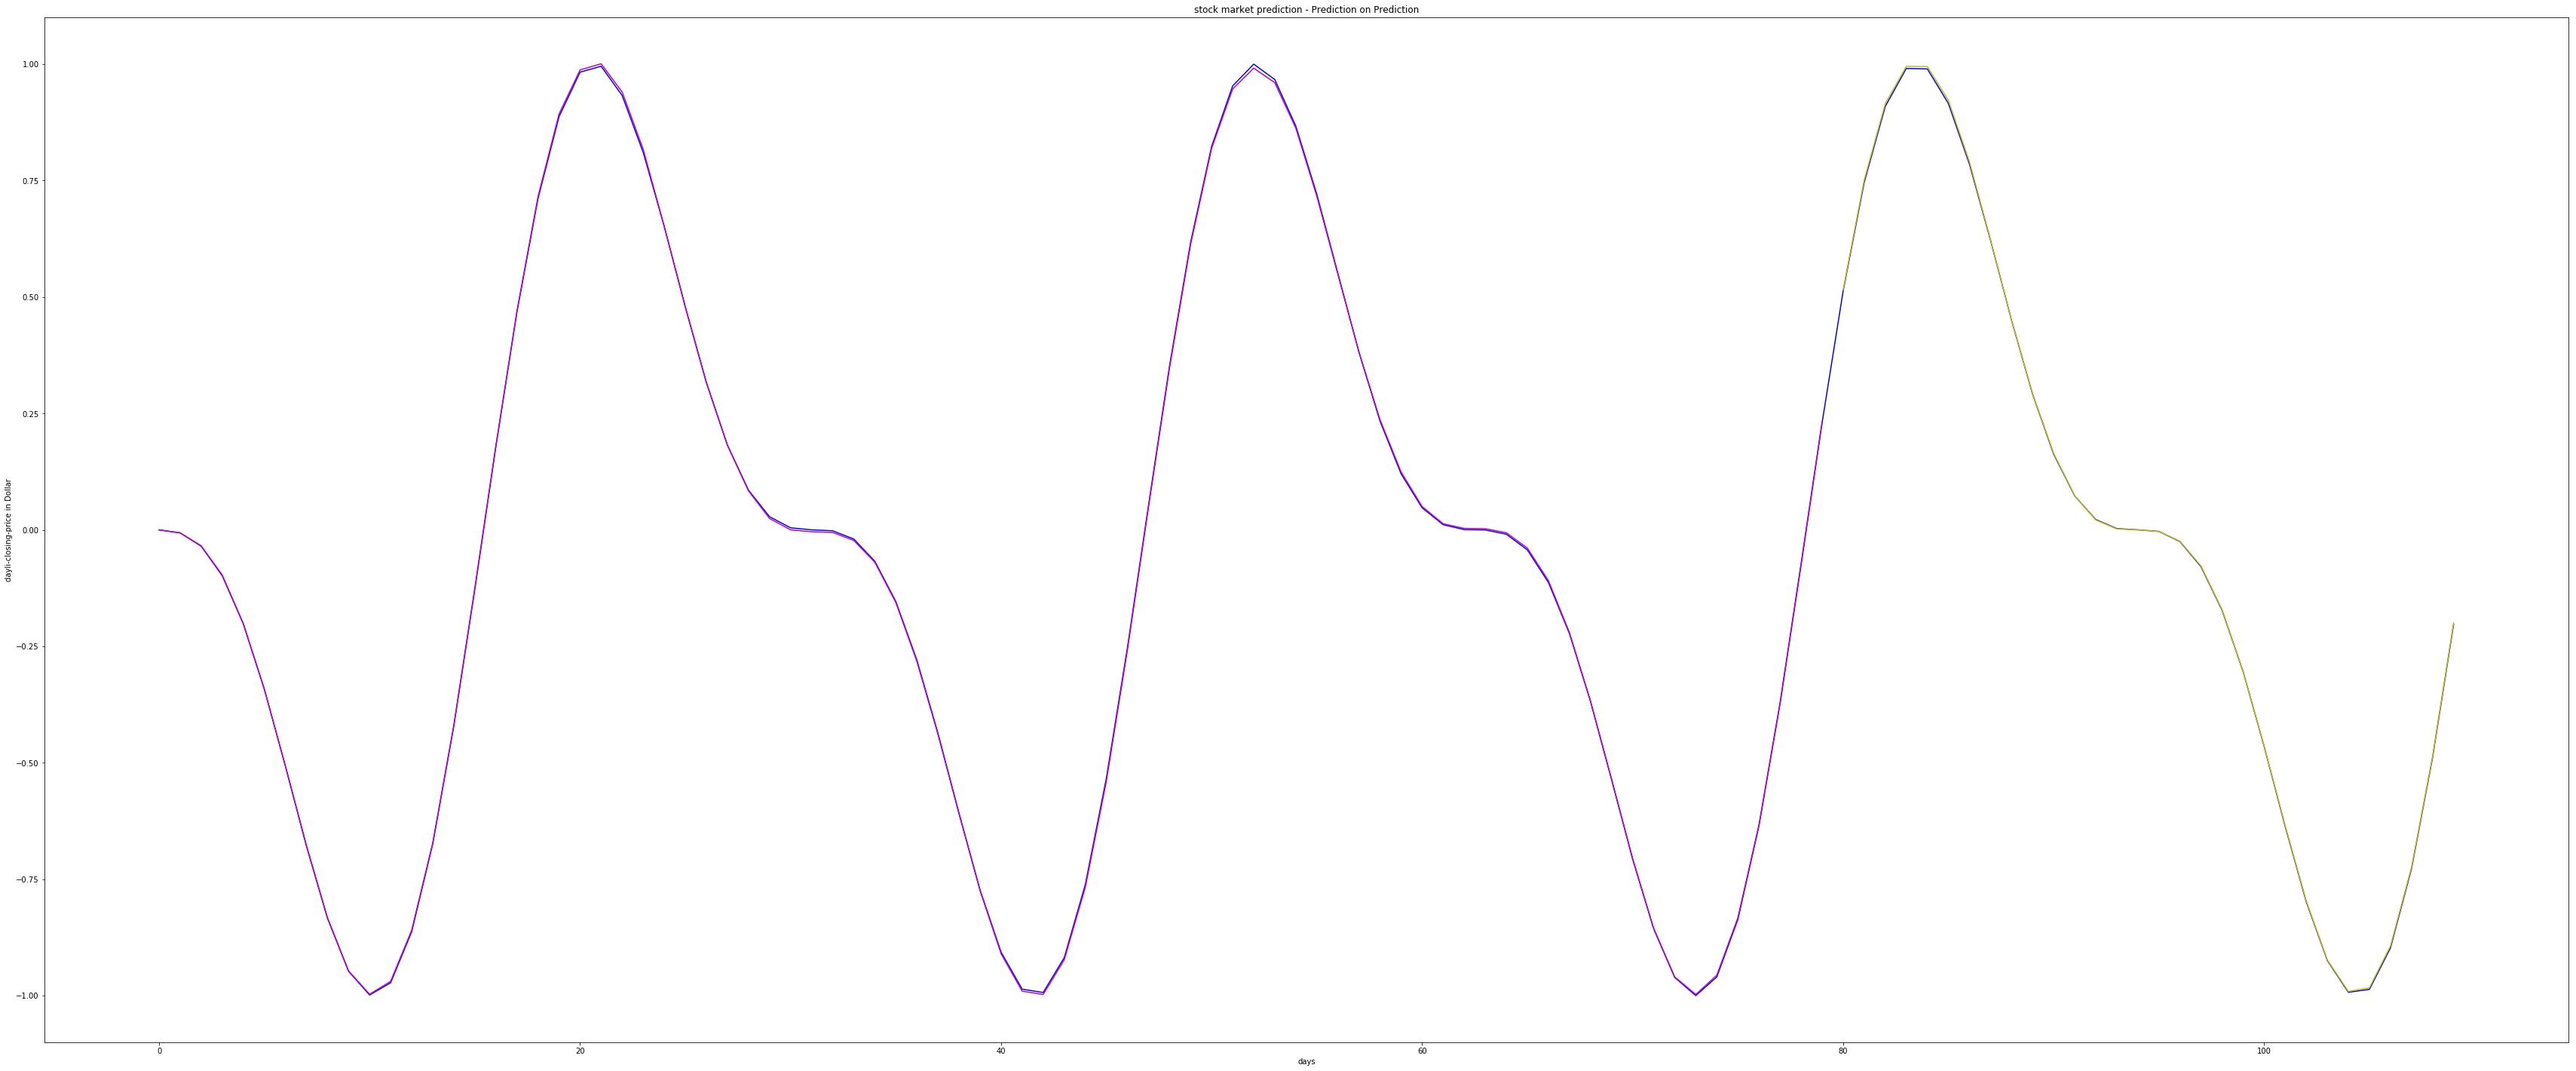

END

NEEDED TIME:  30.124345779418945


In [18]:
if __name__ == "__main__":
    main()

In [19]:
#high - level interface

# log_training = mx.callback.log_train_metric(10)
# mod.fit(train_data=train_iter,
#     eval_data=train_iter,
#     optimizer='adam',
#     optimizer_params={'learning_rate':0.07},
#     eval_metric='mse',
#     num_epoch=50,
#     batch_end_callback=log_training)
#y = predict(mod)

In [20]:
#tests
